# 1.导入所需库 
①Pyproj库：用于进行地理投影坐标系转换；②Xarray：数组相关；③Numpy：用于处理大型矩阵；④zarr：适用于Python的分块,压缩N维数组的实现；

In [1]:
from pyproj import Proj, transform
from math import radians, cos
from io import StringIO
import xarray as xr   
import pandas as pd
import numpy as np
import datetime
import sys
import os
import zarr
import cftime
import rasterio
import geopandas
from osgeo import gdal

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# 2.导入matplotli，用于绘图
使用 %matplotlib inline 命令，可以将matplotlib的图表直接嵌入到Notebook之中

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rc('font', **{'size': 16})

In [3]:
ds = xr.open_dataset("data/MCD43A1.006_500m_aid0001.nc")
ds = ds.rename({"Num_Parameters": "param", "xdim": "x", "ydim": "y"})

ds

<xarray.Dataset>
Dimensions:                                       (time: 10, y: 3045, x: 3265,
                                                   param: 3)
Coordinates:
  * time                                          (time) object 2005-01-01 00...
  * y                                             (y) float64 4.082e+06 ... 2...
  * x                                             (x) float64 6.265e+06 ... 7...
  * param                                         (param) int32 0 1 2
Data variables: (12/21)
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band2      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band3      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (time, y, x) float32 ...
    ...                                            ...
    BRDF_Albedo_Parameters_Band5                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_Band6                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_Band7                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_nir                    (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_shortwave              (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_vis                    (time, y, x, param) float32 ...
Attributes:
    title:        MCD43A1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.2
    references:   See README.md
    history:      See README.md

# 3.测试代码
发现数据沿着三维：time、x、y 组织起来

In [4]:
ds = ds.isel(time=slice(0,10))
ds

<xarray.Dataset>
Dimensions:                                       (time: 10, y: 3045, x: 3265,
                                                   param: 3)
Coordinates:
  * time                                          (time) object 2005-01-01 00...
  * y                                             (y) float64 4.082e+06 ... 2...
  * x                                             (x) float64 6.265e+06 ... 7...
  * param                                         (param) int32 0 1 2
Data variables: (12/21)
    crs                                           int8 -127
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band2      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band3      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (time, y, x) float32 ...
    ...                                            ...
    BRDF_Albedo_Parameters_Band5                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_Band6                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_Band7                  (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_nir                    (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_shortwave              (time, y, x, param) float32 ...
    BRDF_Albedo_Parameters_vis                    (time, y, x, param) float32 ...
Attributes:
    title:        MCD43A1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.2
    references:   See README.md
    history:      See README.md

# 4.坐标和太阳天顶角
①添加lat和lon值的二维数组
②将一些关于质量标志的信息和元数据，分配给Mandatory_Quality变量等

需要纬度和经度来计算太阳天顶角，所以使用numpy和proj库为数据集中的x，y坐标生成lat，lon等效数组。
需要采取以下几个步骤：

# （1）定义SRS
使用pyproj定义源x、y阵列和目标lon、lat阵列的空间信息。

In [5]:
ds.crs

<xarray.DataArray 'crs' ()>
array(-127, dtype=int8)
Attributes:
    grid_mapping_name:                      sinusoidal
    _CoordinateAxisTypes:                   GeoX GeoY
    spatial_ref:                            PROJCS["unknown",GEOGCS["unknown"...
    radius_of_sphere:                       6371007.181
    longitude_of_central_meridian:          0
    longitude_of_projection_origin:         0
    straight_vertical_longitude_from_pole:  0
    false_easting:                          0
    false_northing:                         0

# 使用WGS84的EPSG代码：
错误未解决

In [6]:
from pyproj import CRS
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)

In [7]:
inproj=Proj('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ', preserve_units=True)
outproj = Proj(init="epsg:4326")

In [8]:
xx, yy = np.meshgrid(ds.x.data, ds.y.data)

xx

array([[6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702],
       [6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702],
       [6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702],
       ...,
       [6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702],
       [6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702],
       [6264682.89653035, 6265146.20924688, 6265609.52196341, ...,
        7776008.97784396, 7776472.29056049, 7776935.60327702]])

In [9]:
lon1d, lat1d = transform(
    inproj, 
    outproj, 
    xx.flatten(), 
    yy.flatten())

print("First five (lon,lat) pairs:"); list(zip(lon1d[:5], lat1d[:5]))

First five (lon,lat) pairs:


[(70.27803907880582, 36.710416663369976),
 (70.28323658197328, 36.710416663369976),
 (70.28843408514074, 36.710416663369976),
 (70.2936315883082, 36.710416663369976),
 (70.29882909147565, 36.710416663369976)]

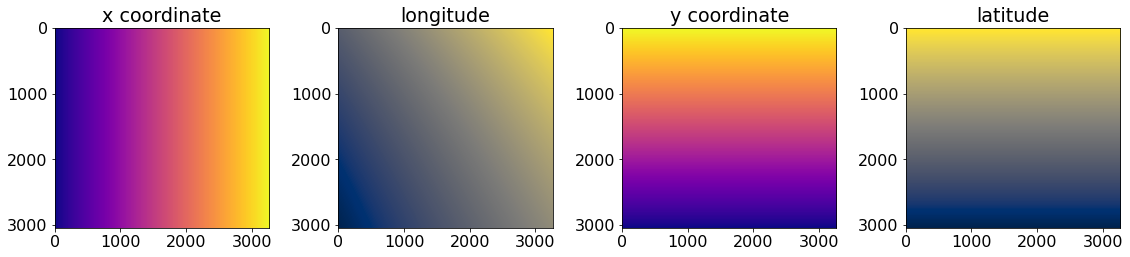

In [10]:
lon2d, lat2d = lon1d.reshape(xx.shape), lat1d.reshape(yy.shape)

# plot
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,4,1)
ax1.imshow(xx, cmap=cm.plasma); 
ax1.set_title("x coordinate")

ax2 = fig.add_subplot(1,4,2, sharey=ax1)
ax2.imshow(lon2d, cmap=cm.cividis); 
ax2.set_title("longitude")

ax3 = fig.add_subplot(1,4,3, sharey=ax1)
ax3.imshow(yy, cmap=cm.plasma); 
ax3.set_title("y coordinate")

ax4 = fig.add_subplot(1,4,4, sharey=ax1)
ax4.imshow(lat2d, cmap=cm.cividis); 
ax4.set_title("latitude")

fig.tight_layout()

In [11]:
ds.coords["lat"] = xr.DataArray(
    data=lat2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))

ds.coords["lon"] = xr.DataArray(
    data=lon2d, 
    coords=[ds.y, ds.x], 
    dims=["y", "x"], 
    attrs=dict(
        standard_name="longitude",
        long_name="longitude coordinate",
        units="degrees_east"))

ds.coords

Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2005-01-10 00:00:00
  * y        (y) float64 4.082e+06 4.082e+06 4.081e+06 ... 2.672e+06 2.672e+06
  * x        (x) float64 6.265e+06 6.265e+06 6.266e+06 ... 7.776e+06 7.777e+06
  * param    (param) int32 0 1 2
    lat      (y, x) float64 36.71 36.71 36.71 36.71 ... 24.03 24.03 24.03 24.03
    lon      (y, x) float64 70.28 70.28 70.29 70.29 ... 76.56 76.57 76.57 76.57

In [12]:
def get_solar_zenith(doy, latitude, ndoy=365):
    """ """
    declination = cos(radians((doy+10)*(360/ndoy)))*-23.45
    altitude = 90 - latitude + declination
    zenith = 90 - altitude
    return(zenith)


sza = get_solar_zenith(ds.time[0].dt.dayofyear, ds.lat[0][0])
sza.name = "solar_zenith_angle"

sza

<xarray.DataArray 'solar_zenith_angle' ()>
array(59.74126212)
Coordinates:
    y        float64 4.082e+06
    x        float64 6.265e+06
    lat      float64 36.71
    lon      float64 70.28

In [13]:
def sza_eval(doy, lat):
    """Convert CF to Python datetime."""
    func = lambda l: get_solar_zenith(doy, l)
    return(xr.apply_ufunc(func, lat))
    
# evaluate sza over all arrays using list comprehension 
sza_arr = np.dstack([sza_eval(t.dt.dayofyear, ds.lat) for t in ds.time])
sza_arr.shape

(3045, 3265, 10)

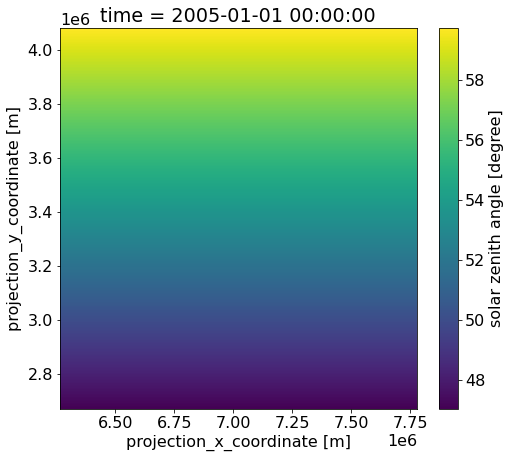

In [14]:
sza = xr.DataArray(
    data=sza_arr, 
    coords=[ds.y, ds.x, ds.time],
    dims=["y", "x", "time"],
    attrs=dict(
        units="degree",
        standard_name="solar zenith angle",
        long_name="solar zenith angle"))

sza = sza.transpose("time", "y", "x")
sza[0].plot(x="x", y="y", figsize=(8,7))

In [15]:
def fBSA(param1, param2, param3, sza):
    """ """
    s = np.radians(sza)
    func = lambda p1, p2, p3: (
        p1*( 1.0      +  0.0     *(s**2) + 0.0     *(s**3)) +  # Isotropic
        p2*(-0.007574 + -0.070987*(s**2) + 0.307588*(s**3)) +  # RossThick
        p3*(-1.284909 + -0.166314*(s**2) + 0.041840*(s**3)))   # LiSparseR
    return(xr.apply_ufunc(func, param1, param2, param3))


b1 = ds["BRDF_Albedo_Parameters_nir"]
param1 = b1.sel(param=0)
param2 = b1.sel(param=1)
param3 = b1.sel(param=2)
bsa = fBSA(param1, param2, param3, sza)

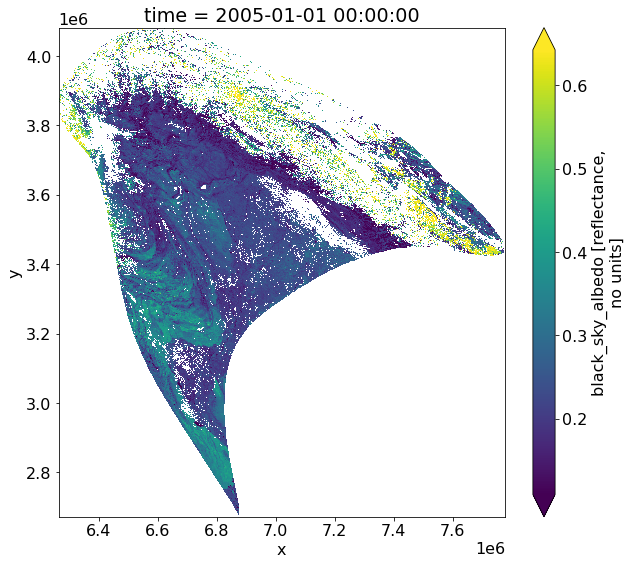

In [16]:
bsa.name = "black_sky_albedo"
bsa.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="black_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

bsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

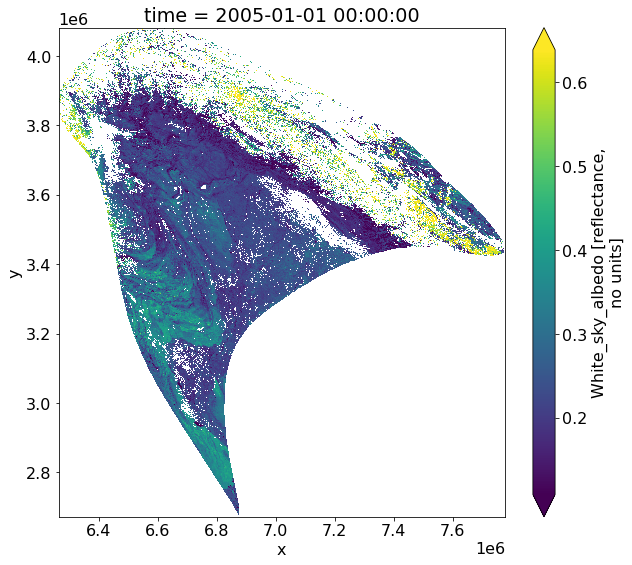

In [17]:
def fWSA(param1, param2, param3):
    """ """
    func = lambda p1, p2, p3: (
        p1* 1.0       +           # Isotropic
        p2* 0.189184  +           # RossThick
        p3*-1.377622 )            # LiSparseR  
    return(xr.apply_ufunc(func, param1, param2, param3))


wsa = fWSA(param1, param2, param3)
wsa.name = "White_sky_albedo"
wsa.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="White_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

wsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

In [19]:
with open("data/skyl_lut.dat", "r") as f:
    tab = f.read().replace("  ", " ")

con, mar = [t.split("Band") for t in tab.split("Aerosol_type: ")[1:]]
luts = {i+1: pd.read_csv(
    StringIO(b),
    index_col="S&O",
    skiprows=1,
    sep=" ") for i, b in enumerate(con[1:])}
   

def lookup(sza, luc):
    """ """    
    lfunc = lambda s: luc.iloc[s].values
    return(xr.apply_ufunc(lfunc, abs(sza).round(),))

In [20]:
sod = "0.20" # solar optical depth 
luv = lookup(sza.data.flatten(), luts[9][sod])
lu = xr.DataArray(
    data=luv.reshape(sza.shape), 
    coords=[sza.time, sza.y, sza.x],
    dims=["time", "y", "x"],
    attrs=dict(
        units="unitless",
        long_name="near-infrared lookup value"))

lu

<xarray.DataArray (time: 10, y: 3045, x: 3265)>
array([[[0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        ...,
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114],
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114],
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114]],

       [[0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        ...,
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114],
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114],
        [0.114, 0.114, 0.114, ..., 0.114, 0.114, 0.114]],

       [[0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        [0.142, 0.142, 0.142, ..., 0.142, 0.142, 0.142],
        ...,
...
        ...,
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113]],

       [[0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        [0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        [0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        ...,
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113]],

       [[0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        [0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        [0.139, 0.139, 0.139, ..., 0.139, 0.139, 0.139],
        ...,
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113],
        [0.113, 0.113, 0.113, ..., 0.113, 0.113, 0.113]]])
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2005-01-10 00:00:00
  * y        (y) float64 4.082e+06 4.082e+06 4.081e+06 ... 2.672e+06 2.672e+06
  * x        (x) float64 6.265e+06 6.265e+06 6.266e+06 ... 7.776e+06 7.777e+06
Attributes:
    units:      unitless
    long_name:  near-infrared lookup value

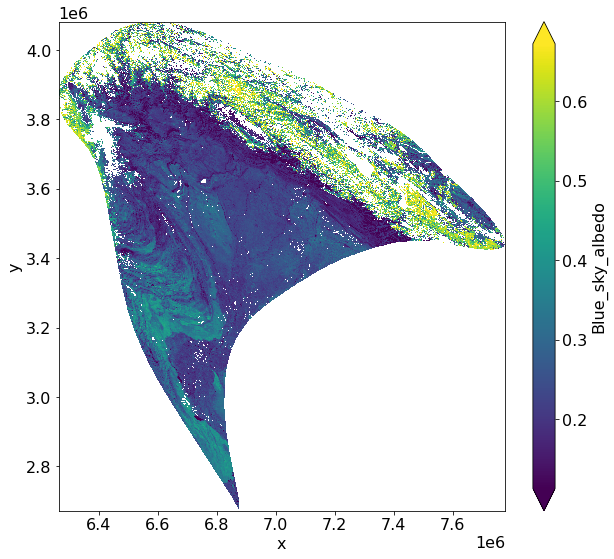

In [21]:
def alb_vectorized(wsa, bsa, lookup):
    """Vectorize albedo polynomials over two 3d arrays."""
    afunc = lambda w,b,l: (w*l)+(b*(1-l))
    return(xr.apply_ufunc(afunc, wsa, bsa, lookup))


alb = alb_vectorized(wsa, bsa, lu)
alb.name = "Blue_sky_albedo"
alb.attrs = dict(
    _FillValue=32767,
    coordinates="time y x",
    grid_mapping="crs",
    valid_min=0,
    valid_max=32766,
    long_name="Blue_sky_albedo",
    units="reflectance, no units",
    scale_factor_err=0.0,
    add_offset_err=0.0,
    calibrated_nt=5,
    scale_factor=0.001,
    add_offset=0.0)

alb.mean("time").plot.pcolormesh(
    x='x', 
    y='y',
    robust=True, 
    figsize=(10, 9),)